# CIFAR10 : CNN Example

In [1]:
!pip install torchinfo
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision      import models,  datasets, transforms

from torchinfo        import summary  

import albumentations as A
from   albumentations.pytorch import ToTensorV2

#!nvidia-smi

## Config


In [ ]:
CFG = {
    'model':      "resnet18",   #     "resnet18"   "ResCNN"  "MobileNet"
    'input':      (3,32,32),    #     shape of input images
    'outputs':    10,           #     number of classes
    'batch_trn':  256,          #     batch size for train
    'batch_tst':  512,          #     batch size for test
}

## CIFAR10 dataset



### Show samples

Files already downloaded and verified
dataset: (50000, 32, 32, 3) 50000
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


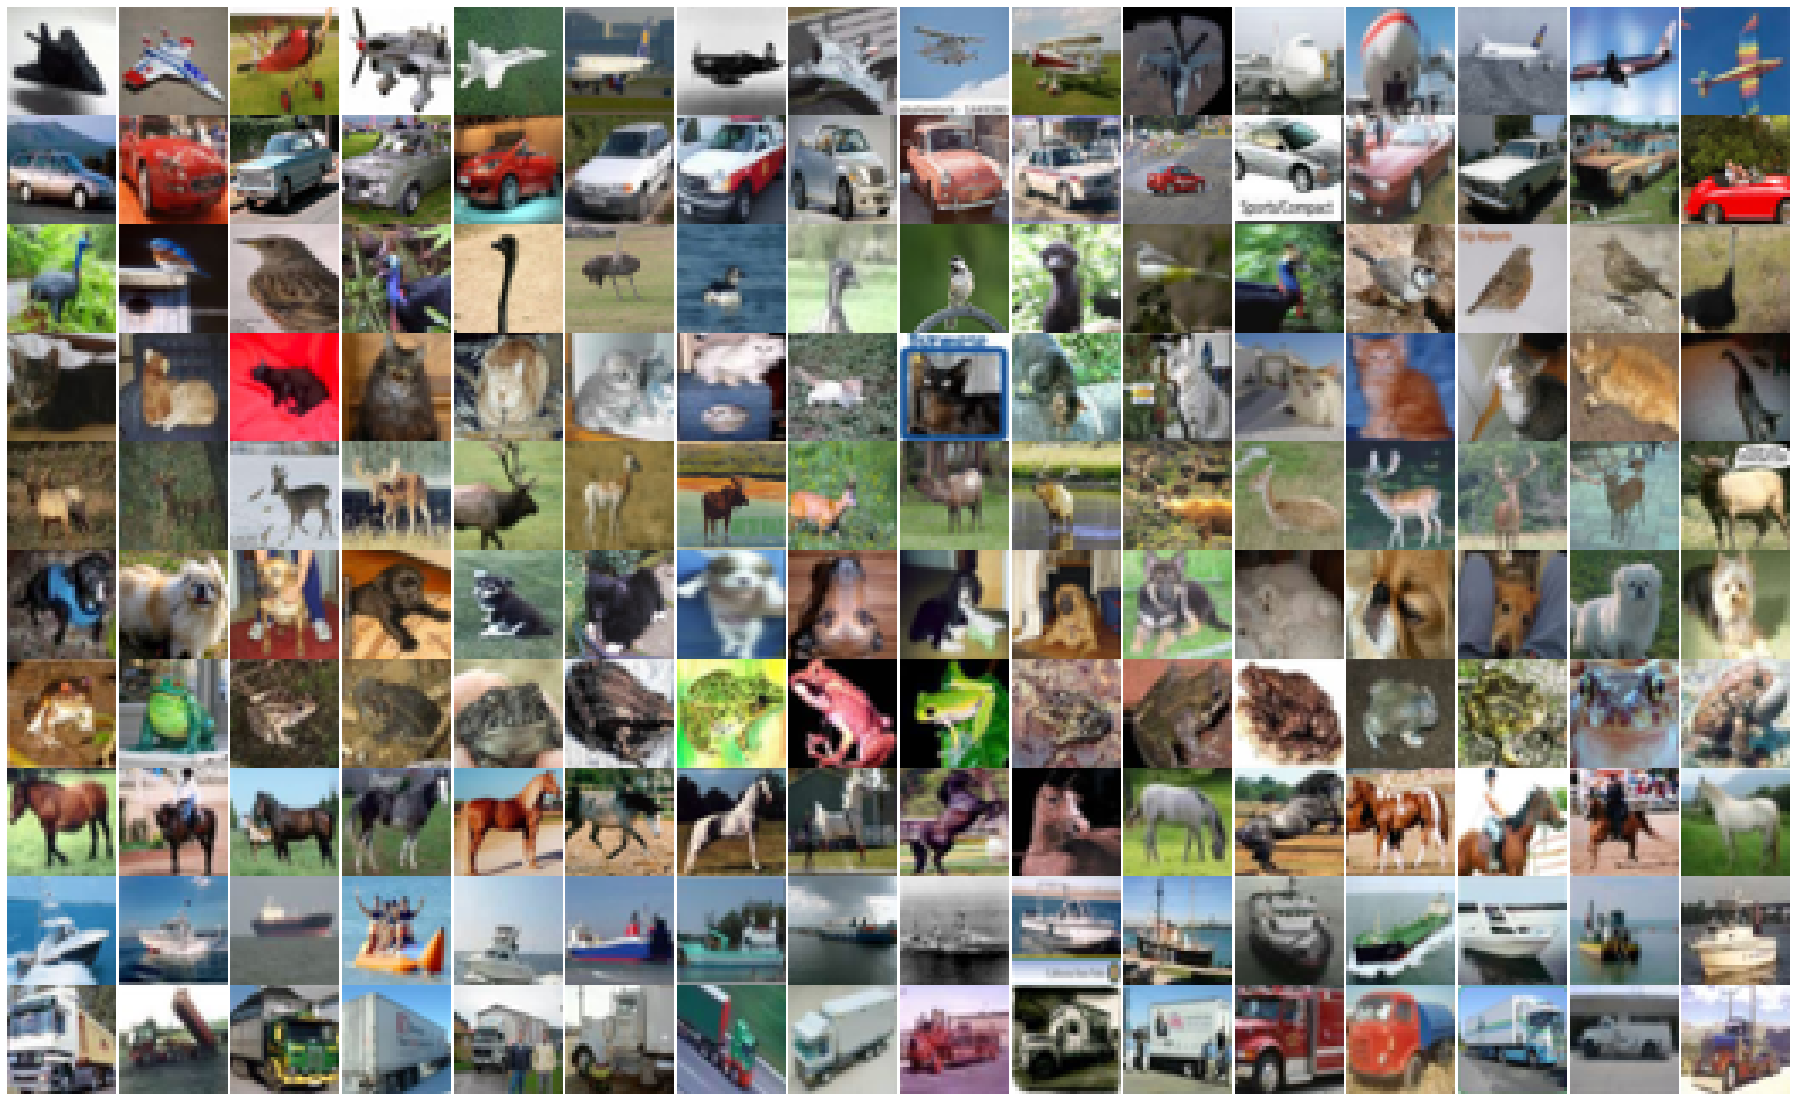

In [ ]:
dataset = datasets.CIFAR10(root = 'data',  download = True)       # for plot images

print("dataset:", dataset.data.shape, len(dataset.targets))
print("classes:", dataset.classes )

i, num_classes, num_samples = 1, 10, 16
plt.figure(figsize=(2*num_samples, 2*num_classes), facecolor ='w')                  
for row in range(num_classes):    
    select = dataset.data[np.array(dataset.targets) == row]    
    for col in range(num_samples):
        ax=plt.subplot(num_classes, num_samples, i)    
        i += 1        
        plt.imshow(select[col]);  plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)        
plt.show()    

### DataLoader with Torchvision transforms

In [ ]:
IMAGE_MEAN = (0.485, 0.456, 0.406)
IMAGE_STD  = (0.229, 0.224, 0.225)

def get_data_loaders(mean, std):
    """ Get samples from DataLoader. It's more slower """
    trn = torch.utils.data.DataLoader(                 # train loader
        datasets.CIFAR10(
            root = 'data', download=True,  train=True, 
            transform = transforms.Compose([
                            transforms.RandomCrop(32, padding=4),
                            transforms.RandomHorizontalFlip(),            
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)]) ),
        batch_size = CFG['batch_trn'],
        shuffle = True
    )

    tst = torch.utils.data.DataLoader(                 # test loader
        datasets.CIFAR10(
            root = 'data', download=True,  train=False, 
            transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std) ]) ),
        batch_size = CFG['batch_tst'],        
    )
    return trn, tst


#loader_trn, loader_tst = get_data_loaders(IMAGE_MEAN, IMAGE_STD)


### DataLoader with Albumentations transforms

In [7]:
class CIFAR10Dataset(Dataset):
    def __init__(self, train, transform):
        self.dataset = datasets.CIFAR10(root = 'data',  download = True, train=train)    
        self.transform = transform

    def __len__(self):
        return len(self.dataset.data)

    def __getitem__(self, idx):
        image = self.dataset.data[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, self.dataset.targets[idx]


transform_trn = A.Compose([
                            A.HorizontalFlip(p=0.5),                                  
                            A.ShiftScaleRotate(rotate_limit=10),
                            A.RandomResizedCrop(height=32, width=32, scale=(0.8, 1.), ratio=(0.9, 1.1)),   
                            A.Normalize(),        
                            ToTensorV2() ])
transform_tst = A.Compose([
                            A.Normalize(),        
                            ToTensorV2() ])

data_trn = CIFAR10Dataset(train=True,  transform=transform_trn)
data_tst = CIFAR10Dataset(train=False, transform=transform_tst)

loader_trn = DataLoader(data_trn, batch_size=CFG["batch_trn"], shuffle=True,  pin_memory=True )    # num_workers=CFG["num_workers"]
loader_tst = DataLoader(data_tst, batch_size=CFG["batch_tst"], shuffle=False, pin_memory=True )

Files already downloaded and verified
Files already downloaded and verified


## Model  ResCNN


In [8]:
class ResBlock(nn.Module):
    def __init__(self, in_channels,  out_channels, kernel = 3, num=2,  mode = 'replicate',  batchnorm=False, residual=True):
        super(ResBlock, self).__init__()    
        self.residual  = residual
        self.batchnorm = None
        layers, channels, padding = [],  [in_channels] + [out_channels]*num,   kernel // 2
        for i in range(len(channels)-1):            
            layers += [ nn.Conv2d(channels[i], channels[i+1], kernel_size=kernel, stride=1,  padding=padding, padding_mode=mode) ]
            if batchnorm:
                layers += [ nn.BatchNorm2d(num_features=channels[i+1]) ]
            if i < len(channels)-2:
                layers += [ nn.ReLU() ]
        
        self.block = nn.Sequential(*layers)              
        if residual:
            self.align = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            if batchnorm:
                self.batchnorm = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):                       
        y = self.block(x)
        if self.residual:
            y2 = self.align(x)
            if not self.batchnorm is None:
                y2 = self.batchnorm(y2)
            y +=  y2
        return nn.ReLU()(y)

class ResCNN(nn.Module):
    def __init__(self,
                 shape   = (1, 64, 64),                                              # Input image shape (channels, height, width)        
                 outputs = 1,                                                        # Number of outpust 
                 channels = [], kernels=[],  mode='replicate',                       # Conv2d
                 batchnorm=False,                                                    # batchnorm
                 pools=2,                                                            # Pooling
                 dropouts=0.,                                                        # Dropout
                 hiddens=[],                                                         # Add output hidden layers
                 residual = True                                                     # Add residual path    
                 ):                                                        
        super(ResCNN, self).__init__()             

        if type(pools)    == int:    pools    = [pools]*len(channels)            
        if type(dropouts) == float:  dropouts = [dropouts]*(len(hiddens) + 1)   
        if not kernels:              kernels  = [3]*len(channels)   
        if type(kernels) == int:     kernels  = [kernels]*len(channels)   

        in_channels, h, w = shape                                                      
        channels = [in_channels] + channels
        self.layers = []
        for i in range(len(channels)-1):            
            self.layers +=  [ ResBlock(channels[i], channels[i+1], kernel=kernels[i], mode=mode, residual=residual)  ]            
            if pools[i] > 1:
                self.layers += [ nn.MaxPool2d(kernel_size = pools[i], stride = pools[i]) ]                
                h = int( (h - pools[i]) / pools[i] + 1)
                w = int( (w - pools[i]) / pools[i] + 1)
                
        self.layers += [ nn.Flatten(1) ]

        hiddens = [channels[-1] * h * w] + hiddens + [ outputs ]
        for i in range( len(hiddens)-1):
            if dropouts[i] > 0:        
                self.layers += [ nn.Dropout(p=dropouts[i]) ]    
            self.layers += [ nn.Linear(hiddens[i], hiddens[i+1] ) ]
            if i < len(hiddens)-2:                            
                self.layers += [ nn.ReLU() ]

        self.model = nn.Sequential(*self.layers)                 
 
    def forward(self, x):               
        return self.model(x)

    def get(self, x):
        res = []
        for layer in self.layers:
            x = layer(x)
            res.append(x.data.cpu().numpy())
        return res           

### Create Model

In [9]:
if CFG['model'] == 'ResCNN':
    CFG['residual'] =  False
    CFG['channels']=  [64,128, 128, 256,  256]
    CFG['kernels']=   3    
    CFG['mode']=      'replicate'              #'replicate', 'zeros'
    CFG['pools']=     [ 2, 0,   2,  0,    2 ]
    CFG['batchnorm']= True
    CFG['dropout']=   0.2    
    CFG['lr']=        1e-4  
    CFG['L2']=        1e-6
    CFG['hiddens'] =  []          

    model = ResCNN(shape       = CFG['input'], 
                   outputs     = CFG['outputs'],
                   channels    = CFG['channels'],
                   kernels     = CFG['kernels'], 
                   mode        = CFG['mode'],  
                   pools       = CFG['pools'],
                   batchnorm   = CFG['batchnorm'],                                           
                   dropouts    = CFG['dropout'],
                   hiddens     = CFG['hiddens'],
                   residual    = CFG['residual'])

## Model  CNN

In [10]:
class CNN(nn.Module):
    def __init__(self, 
                 shape   = (1, 64, 64),                                              # Input image shape (channels, height, width)        
                 outputs = 1,                                                        # Number of outpust 
                 channels = [], conv_kernels=[], conv_stride=1,  paddings=1, mode='replicate',      # Conv2d
                 batchnorm=False,                                                    # batchnorm
                 pool_kernel=2, pool_stride=2,  pool="max",         # Pooling
                 dropout=0.2,                                                        # Dropout
                 hiddens=None):                                                      # Add output hidden layers
        super(CNN, self).__init__()

        if paddings          == None: paddings    = 0                            # default
        if type(paddings)    == int:  paddings    = [paddings]   *len(channels)
        if conv_stride       == None: conv_stride = 1                            # default
        if type(conv_stride) == int:  conv_stride = [conv_stride]*len(channels)
        if pool_kernel       == None: pool_kernel = 2                            # default
        if type(pool_kernel) == int:  pool_kernel = [pool_kernel]*len(channels)    
        if type(pool_stride) == int:  pool_stride = [pool_stride]*len(channels)
        if not hiddens:               hiddens = []

        in_channels, h, w = shape                                                      
        channels = [in_channels] + channels
        self.layers = []
        for i in range(len(channels)-1):
            if conv_kernels[i]:
                self.layers +=  [ 
                    nn.Conv2d(channels[i], channels[i+1], kernel_size=conv_kernels[i], stride=conv_stride[i],  padding=paddings[i], padding_mode=mode),
                ]
                if batchnorm:                          # beetwen Line and non line   http://arxiv.org/pdf/1502.03167v2.pdf
                    self.layers += [ nn.BatchNorm2d(num_features=channels[i+1]) ]
                self.layers += [ nn.ReLU() ]             

                h = int( (h + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)
                w = int( (w + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)  
            
            if pool_kernel[i] > 1:
                if pool == 'max': self.layers += [nn.MaxPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                else:             self.layers += [nn.AvgPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                h = int( (h - pool_kernel[i]) / pool_stride[i] + 1)
                w = int( (w - pool_kernel[i]) / pool_stride[i] + 1)
                
        self.layers += [ nn.Flatten(1) ]

        hiddens = [channels[-1] * h * w] + hiddens + [outputs]
        for i in range( len(hiddens)-1):
            if dropout > 0:        
                self.layers += [ nn.Dropout(p=dropout) ]
        
            self.layers += [ nn.Linear(hiddens[i], hiddens[i+1] ) ]
            if i < len(hiddens)-2:                              # for probability after this need sigmoid (we used BCEWithLogitsLoss)
                self.layers += [ nn.ReLU() ]

        self.model = nn.Sequential(*self.layers)                 
 
    def forward(self, x):               
        return self.model(x)

    def get(self, x):
        res = []
        for layer in self.layers:
            x = layer(x)
            res.append(x.data.cpu().numpy())
        return res

### Create Model

In [11]:
if CFG['model'] == 'CNN':
    CFG = {
        'input':     (CHANNELS,)+IMAGE_SIZE,
        'outputs':   NUM_CLASSES,
    
        'channels':  [32,32,64,64],                        
        'kernels':   [3, 3, 3, 3, 3, 3],
        'strides':   [1, 1, 1, 1, 1, 1],
        'paddings':  [1, 1, 1, 1, 1, 1],
        'mode':      'replicate',   #'replicate', 'zeros'
        'pool_ker':  [0, 2, 0, 2, 0, 2],
        'pool_str':  [2, 2, 2, 2, 0, 2],
        'batchnorm': False,
        'dropout':   0.5,
        'batch':     128,
        'lr':        1e-3,  
        'L2':        1e-4,
        'hiddens':  [100]      
    } 

    model = CNN(shape = CFG['input'], outputs = CFG['outputs'],
                channels=CFG['channels'], conv_kernels=CFG['kernels'], conv_stride=CFG['strides'],  paddings=CFG['paddings'], mode=CFG['mode'],   # Conv2d        
                pool_kernel=CFG['pool_ker'], pool_stride=CFG['pool_str'],  pool="max",                               
                batchnorm=CFG['batchnorm'],                                                    # batchnorm
                dropout = CFG['dropout'],
                hiddens = CFG['hiddens'])

## MobileNet

In [12]:
if CFG['model'] == 'MobileNet':
    CFG = {
        'input':     (CHANNELS,)+IMAGE_SIZE,
        'outputs':   NUM_CLASSES,    
        'alpha':     0.5,
        'dropout':   0.1,
        'batch':     128,
        'lr':        1e-3,  
        'L2':        1e-4,        
    } 
    model = models.mobilenet_v2(num_classes=CFG['outputs'], pretrained=False,  
                                width_mult=CFG['alpha'],           # width_mult: float = 1.0,
                                dropout = CFG['dropout'])          # dropout: float = 0.2 (default); keras: dropout=0.001,

## ResNet

In [13]:
if CFG['model'] == 'resnet18':
    CFG['lr'] = 1e-3
    CFG['L2'] = 1e-5

    model = models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    
    if False:                                                      # if pretrained=True
        for name, param in model.named_parameters():
            if 'fc' not in name:
                #print(name, param.requires_grad)
                param.requires_grad=False


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Device and Model Info

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

print(device)

tot = 0
for k, v in model.state_dict().items():
    pars = np.prod(list(v.shape))    
    if type(pars) == np.int64:
        tot += pars
    #print(f'{k:20s} :{pars:7d}  =  {tuple(v.shape)} ')
print(f"{'parameters':20s} :{tot:7d}")

model.to(device)

CFG['params'] = tot
summary(model, (1,3,32,32), col_names=["kernel_size", "output_size", "num_params"], depth=4) 

cuda:0
parameters           :11183562


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
ResNet                                   --                        [1, 10]                   --
├─Conv2d: 1-1                            [3, 3]                    [1, 64, 32, 32]           1,728
├─BatchNorm2d: 1-2                       --                        [1, 64, 32, 32]           128
├─ReLU: 1-3                              --                        [1, 64, 32, 32]           --
├─Identity: 1-4                          --                        [1, 64, 32, 32]           --
├─Sequential: 1-5                        --                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   --                        [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [3, 3]                    [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             --                        [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3     

## Network learning

It is better to put all the training data in GPU memory. So it will be faster. However, with a large number of examples, memory may not be enough. Therefore, each batch is sent to memory.

### Functions

In [15]:
def fit(model, loader, train=True):         
    """ One epoch training for DataLoader """    
    t1, t2, t3, t4, t5, start = 0,0,0,0,0,time.process_time()
    totLoss, totAcc, totNum   = 0,0,0       

    model.train(train)                                 # important for Dropout, BatchNorm layers
    for sample in loader:                             
        beg = time.process_time()                        
        xb, yb = sample[0].to(device), sample[1].to(device)         
        t1 += (time.process_time() - beg)

        beg = time.process_time()                            
        y = model(xb)                                   # forward propagation
        L = loss(y, yb)                                 # calculate the loss
        t2 += (time.process_time() - beg)

        if train:                                       # we are in learning mode
            beg = time.process_time()                            
            optimizer.zero_grad()                       # reset the gradients        
            L.backward()                                # calculate gradients           
            optimizer.step()                            # adjusting parameters
            t3 += (time.process_time() - beg)                                     
        
        beg = time.process_time()                                    
        totLoss += L.detach()                           # total loss (detach from graph)        
        a = y.data.argmax(axis=1)                   
        totAcc +=  (a == yb).float().mean()             # class definition accuracy
        totNum += 1
        t4 += (time.process_time() - beg)                                      

    beg = time.process_time()
    totLoss = totLoss.item()/totNum                     # item better hear (gpu!!!)
    totAcc  = totAcc.item() /totNum
    t5 = time.process_time() - beg

    info = f"gpu:{t1:.2f} nn:{t2:.2f} grad:{t3:.2f} met:{t4:.2f} av:{t5:.2f} tot:{time.process_time()-start:.2f}"
    return totLoss, totAcc, info             # mean loss and accuracy

#-------------------------------------------------------------------------------
def param_metrics(model):
    grads = []    
    with torch.no_grad():
        L2 = sum(p.data.pow(2).sum() for p in model.parameters()).cpu().item()
        for p in model.parameters():                 
            if not p.grad is None:
                grads += [(((p.grad)**2).mean()**0.5).item()]
    return L2, grads

#-------------------------------------------------------------------------------
def smooth(x, beta=0.75): 
    """ Smoothing line plot """   
    av = np.copy(x)
    for i in range(1, len(x)):                
        av[i] = beta*av[i-1]+(1-beta)*x[i]        
    return av

#-------------------------------------------------------------------------------
def plot_train(history, grads, alpha=0.3):
    """ Plot loss and accuarcy: history = [epoch, L_trn, L_tst, L2, A_trn, A_tst] """
    h = np.array(history)                               # learning output
    plt.figure(figsize=(16,5), facecolor ='w')              
    ax1 = plt.subplot(1, 2, 1);  
    ax2=ax1.twinx()  
    ax3=ax1.twinx()      

    ax1.grid(color='gray', linestyle='--', alpha=0.6)
    ax1.set_xlabel('epoch');  ax1.set_ylabel('loss')
    ax1.set_title(f"loss_trn: {h[-1,1]:.4f}, loss_tst: {h[-1,2]:.4f}")

    ax3.plot(np.linspace(0, h[-1, 0],  len(grads)), grads, color="c", marker=".",  alpha=alpha)    
    ax3.set(  xlim=(0, len(grads) ) )
    ax3.legend(['grad'], loc='lower left')    
    ax3.axes.xaxis.set_visible(False); ax3.axes.yaxis.set_visible(False)  
    ax2.plot(h[:,0], h[:,3], ":r"); ax2.set_ylabel('L2');   
    ax2.legend(['L2'], loc='center left')    

    ax1.set( ylim=(0, 0.8), xlim=(0, h[-1,0]) )    
    ax1.plot(h[:,0], smooth(h[:, 1]), "-b")
    ax1.plot(h[:,0], smooth(h[:, 2]), "-g")      
    ax1.legend(['loss trn', 'loss tst'], loc='upper left')  
    ax1.plot(h[:,0], h[:, 1], "-b",  alpha=alpha)
    ax1.plot(h[:,0], h[:, 2], "-g",  alpha=alpha)

    ax = plt.subplot(1, 2, 2);      
    plt.xlabel('epoch'); plt.ylabel('accuracy');  ax.set_title(f"acc_trn: {h[-1,4]:.4f}, acc_tst: {h[-1,5]:.4f}")
    ax.set( ylim=(0.5, 1.0), xlim=(0, h[-1,0]) )
    plt.plot(h[:,0], smooth(h[:, 4]), "-b")
    plt.plot(h[:,0], smooth(h[:, 5]), "-g")
    ax.legend( ['acc trn', 'acc tst'], loc='upper left' )
    plt.plot(h[:,0], h[:, 4], "-b",  alpha=alpha)
    plt.plot(h[:,0], h[:, 5], "-g",  alpha=alpha)
    ax.grid(color='gray', linestyle='--', alpha=0.6)
    
    pars = [ f"{k:10s}: {v}\n" for k,v in CFG.items() ]
    ax.text(h[0,0]+5, 0.5, "".join(pars), {'fontsize':12, 'fontname':'monospace'})
    plt.show()

### Run training

before:      loss: 2.819211 accuracy: 0.100307
epoch:   50 loss:  0.0824 (  0.3259) L2:30223.4297 acc:0.9721 (0.9112) [25.8s] trn: gpu:7.36 nn:1.41 grad:3.34 met:0.03 av:0.02 tot:24.19

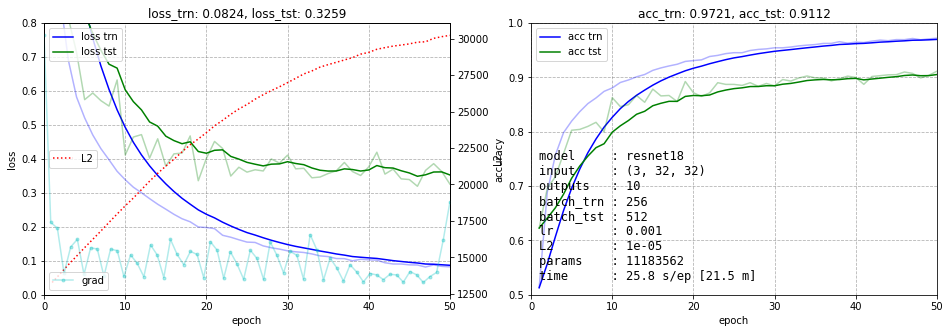

epoch:  100 loss:  0.0502 (  0.3846) L2:30277.9102 acc:0.9826 (0.9071) [25.8s] trn: gpu:7.39 nn:1.41 grad:3.33 met:0.03 av:0.02 tot:24.16

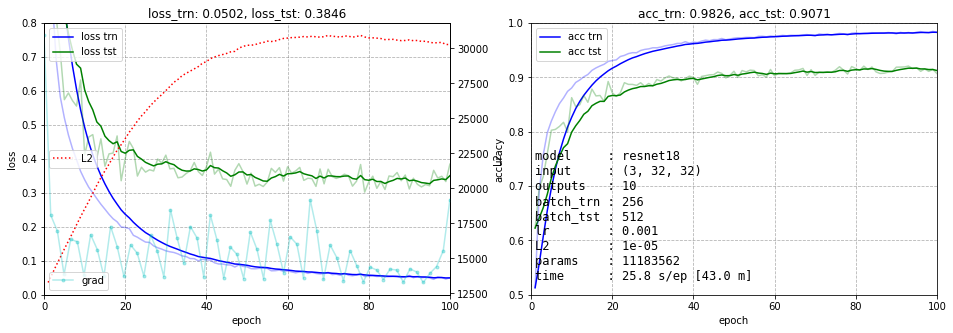

epoch:  150 loss:  0.0391 (  0.3311) L2:28671.4883 acc:0.9864 (0.9154) [25.8s] trn: gpu:7.49 nn:1.41 grad:3.33 met:0.03 av:0.02 tot:24.17

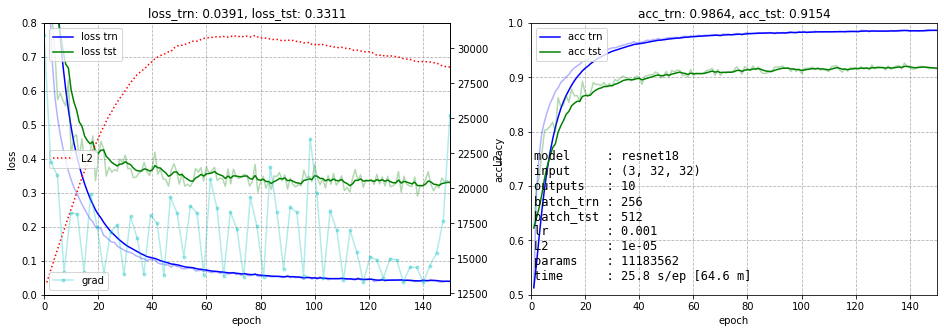

epoch:  200 loss:  0.0351 (  0.3501) L2:27199.1152 acc:0.9881 (0.9188) [25.8s] trn: gpu:7.64 nn:1.41 grad:3.28 met:0.03 av:0.02 tot:24.21

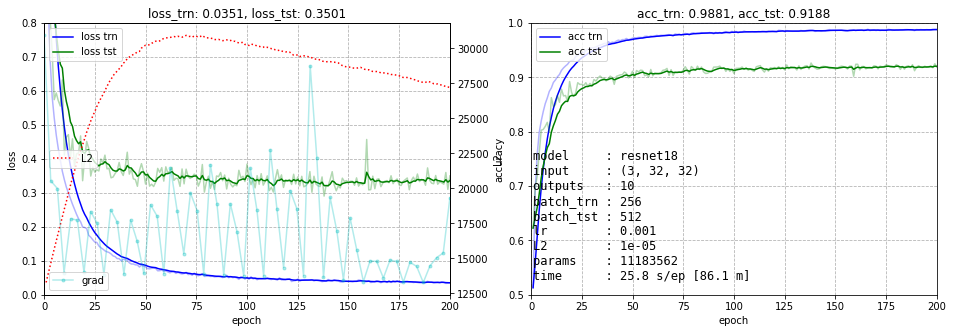

epoch:  250 loss:  0.0351 (  0.3231) L2:25863.4609 acc:0.9884 (0.9216) [25.8s] trn: gpu:7.60 nn:1.40 grad:3.31 met:0.03 av:0.02 tot:24.17

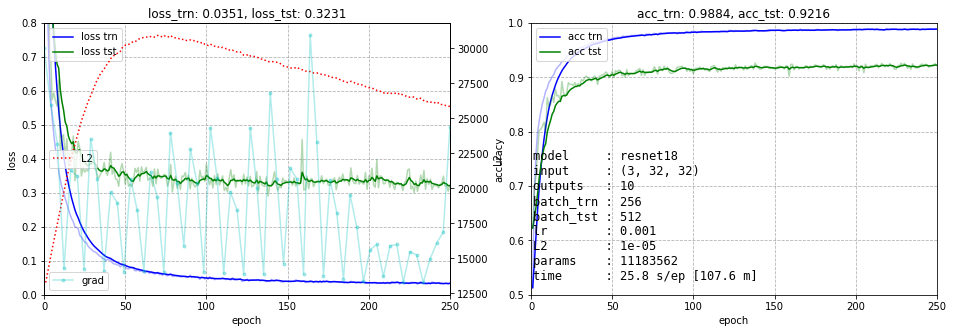

epoch:  300 loss:  0.0327 (  0.3453) L2:24623.9902 acc:0.9888 (0.9179) [25.8s] trn: gpu:7.48 nn:1.41 grad:3.34 met:0.03 av:0.02 tot:24.20

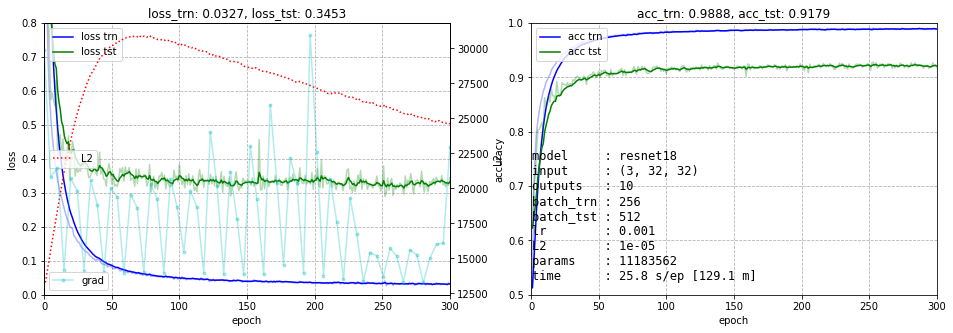

epoch:  350 loss:  0.0310 (  0.3185) L2:23641.8594 acc:0.9899 (0.9236) [25.9s] trn: gpu:7.60 nn:1.41 grad:3.30 met:0.03 av:0.02 tot:24.25

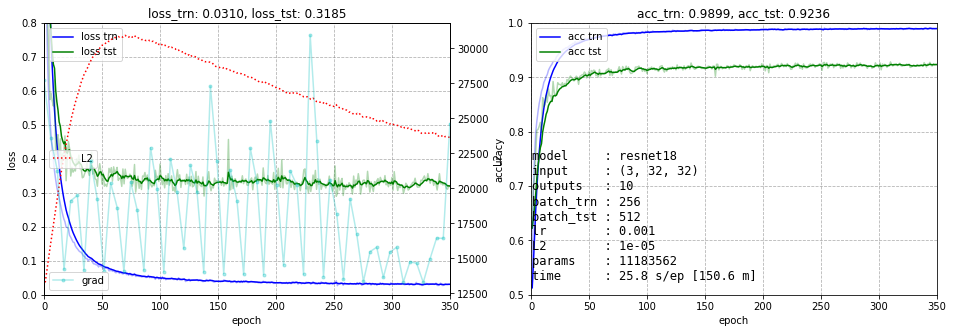

epoch:  400 loss:  0.0303 (  0.3192) L2:22701.5840 acc:0.9899 (0.9267) [25.8s] trn: gpu:7.34 nn:1.42 grad:3.34 met:0.03 av:0.02 tot:24.19

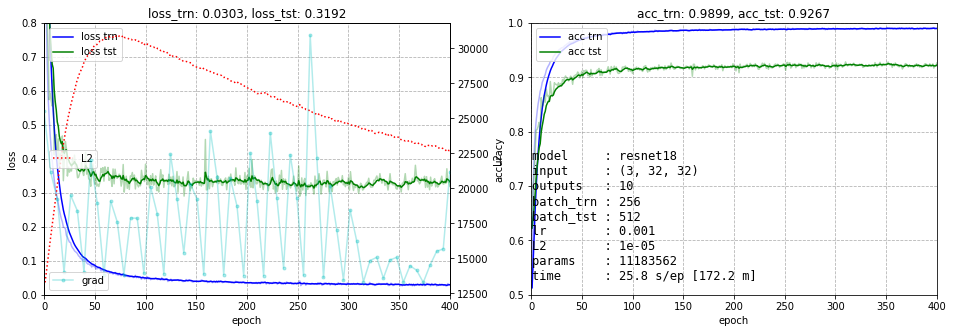

epoch:  450 loss:  0.0285 (  0.3332) L2:22048.6406 acc:0.9900 (0.9246) [25.8s] trn: gpu:7.95 nn:1.38 grad:3.24 met:0.03 av:0.02 tot:24.16

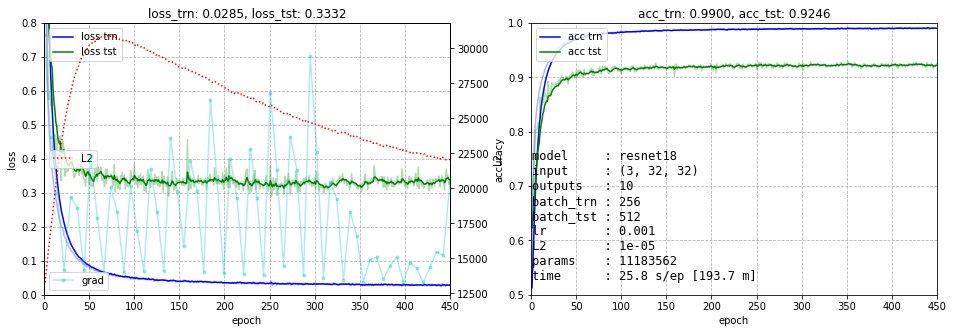

epoch:  464 loss:  0.0291 (  0.3245) L2:21846.2461 acc:0.9902 (0.9241) [25.9s] trn: gpu:7.73 nn:1.40 grad:3.28 met:0.03 av:0.02 tot:24.28

In [ ]:
loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['L2'])   

epochs = 10000
model.to(device) # just in case

L_tst, A_tst, _ = fit(model, loader_trn, train=False)
print( "before:      loss: %8.6f accuracy: %.6f" % (L_tst, A_tst)  )

history, losses, accs, beg, start = [], [], [], time.process_time(), time.process_time()
for epoch in range(1, epochs+1):   
    
    L, A, info = fit(model, loader_trn, train=True)        # train one epoch
    losses.append(L); accs.append(A)    
    
    L_tst, A_tst, _ = fit(model, loader_tst, train=False)  # test and metrics
    L2, grads = param_metrics(model)   

    if epoch % 1 == 0:                                                   # learning output   
        print(f"\repoch:{epoch:5d} loss:{L:8.4f} ({L_tst:8.4f}) L2:{L2:.4f} acc:{A:.4f} ({A_tst:.4f}) [{time.process_time()-beg:.1f}s] trn: {info}", end="")           
        beg = time.process_time()                

    history.append([epoch, L, L_tst, L2, A, A_tst])

    if epoch % 50  == 0 or epoch == epochs:
        CFG['time'] = f"{(time.process_time()-start)/epoch:.1f} s/ep [{(time.process_time()-start)/60:.1f} m]"
        plot_train(history, grads)

## Plot wrong tests

In [ ]:
def get_wrong(model, X,Y, batch_size=100):            
    batch_size = min(batch_size, len(X))      
    model.train(False)                                 # important for Dropout, BatchNorm layers
    wrong   = torch.tensor([], dtype=torch.int64)
    classes = torch.tensor([], dtype=torch.int64)
    sumL, sumA, numB = 0, 0, len(X) // batch_size      # error, accuracy, batches    
    for i in range(0, numB*batch_size, batch_size):             
        nb = min(batch_size,  len(Y)-i)
        xb = X[i: i+nb].to(device)                      # current batch                
        yb = Y[i: i+nb].to(device)               

        y = model(xb)                                   # forward propagation         
        L = loss(y, yb) 

        sumL += L.item()                                # total loss (item from graph)
        
        a = y.argmax(axis=1)        
        sumA += (a == yb).float().mean().item()         # class definition accuracy
        
        classes = torch.cat([classes, a.cpu()], axis=0)        
        wrong   = torch.cat(  [wrong, i + (a != yb).cpu().nonzero(as_tuple=True)[0] ], axis=0  ) 
        
    return sumL/numB,  sumA/numB, wrong.numpy(), classes.numpy()       # mean loss, accuracy, errosrs

L, A, wrong, classes = get_wrong(model, X_tst,Y_tst, 200)
print(L,A)
print(wrong)

count = len(wrong)
print(count)
plt.figure(figsize=(16, 5))         
for i in range(count):    
    plt.subplot(4, count // 4 + 1, i+1)    
    plt.title(f"{Y_tst[wrong[i]]} -> {classes[wrong[i]]}")
    img = X_tst[wrong[i]].view(IMAGE_SIZE).long().numpy()
    plt.imshow( 1-img , cmap='gray')
    plt.axis('off')
plt.show()    

### Confusion matrix

In [ ]:
from   sklearn.metrics import confusion_matrix
import seaborn as sn

matrix = confusion_matrix(Y_tst.numpy(), classes )

print("total accuracy:", matrix.diagonal().sum()/matrix.sum())
print("classes accuracy:", matrix.diagonal()/matrix.sum(axis=1))

matrix = matrix / matrix.sum(axis=1)
plt.figure(figsize = (5,5))
sn.heatmap(matrix, annot=True, cmap="Greys", annot_kws={"size": 12}, fmt=".3f", cbar=False)
plt.show()

## Feature maps

In [ ]:
N_images = NUM_CLASSES*2
X, Y = create_shapes(NUM_CLASSES, 2)
X = np.array(X).mean(axis=3, keepdims=True)

inp  = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)/255.  # channel first

plt.figure(figsize=(25, 5))                   # plot the 16 examples
for lv in range(1):
    for i in range(N_images):    
        plt.subplot(1, 12, i+1)    
        plt.title(f"{Y[i]}")
        plt.imshow(255-X[i].reshape(IMAGE_SIZE), cmap="gray")
        plt.axis('off')
plt.show()    

In [ ]:
print(model)
layers = model.get(inp.to(device))
layerID = [2,5]

num = 0
for i in range(len(layerID)):     # by layer
    layer = layers[layerID[i]]
    num += layer.shape[1]
    print(layer.shape)

tot = 1
plt.figure(figsize=(4*N_images, 4*(num+1)), facecolor ='w') 

for k in range(N_images):        # by image            
    plt.subplot(num+1, N_images, tot)        
    tot += 1            
    plt.imshow(255-X[k].reshape(IMAGE_SIZE), cmap="gray")
    plt.axis('off')

for i in range(len(layerID)):                # by layer
    layer = layers[layerID[i]]        
    for j in range(layer.shape[1]):          # by channel
        for k in range(N_images):        # by image
            ax = plt.subplot(num+1, N_images, tot)    
            tot += 1            
            if k == 0 and j == 0:
                plt.title(str(model.layers[layerID[i]-2]) + "  ->  " + str(model.layers[layerID[i]-1]) + "  ->  "+  str(model.layers[layerID[i]]), loc="left", fontsize=28)
            
            img = layer[k,j]
            plt.imshow(img.max()-img, cmap="gray", vmin = img.min(), vmax = img.max())  # "bwr"
            #ax.set( xlim=(0, img.shape[0]), ylim=(0, img.shape[1]) )
            ax.set_xticks(np.linspace(0, img.shape[0], 9 ))
            ax.set_yticks(np.linspace(0, img.shape[1], 9 ))
            ax.grid(color='lightgray', linestyle='--', alpha=0.6)
            

plt.show()   


## SHEP Plots

In [ ]:
import shap

e = shap.DeepExplainer(model, X_tst.to(device))
shap_values = e.shap_values(inp.to(device))

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(inp.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, test_numpy)